In [1]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

import glob

sys.path.append('..')
import models_mae
from torchvision import transforms

/mnt/sfs_turbo/jiaoxianfeng/.conda/envs/ssl-pretrain/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 得到 CT 图像的均值和标准差

In [2]:
root_dir = r"/mnt/sfs_turbo/jiaoxianfeng/code/ssl-pretrain/mae/datasets/large-COVID-19-ct-slice-dataset/train"
# root_dir = r"/mnt/sfs_turbo/public_medical_images/datasets/selected4finetune/UCSD-AI4H-COVID-CT-data/Images-processed"
class_dirs = os.listdir(root_dir)
mean, std = 0, 0
count = 0

for sub_dir in class_dirs:
    for file_path in glob.glob(os.path.join(root_dir, sub_dir, '*.png')):
        img = np.array(Image.open(file_path))
        img = transforms.functional.to_tensor(img)
        mean += torch.mean(img)
        std += torch.std(img)
        count += 1

print('mean: ', mean / count)
print('std: ', std / count)

KeyboardInterrupt: 

### Define utils

In [24]:
imagenet_mean = np.array([0.2755])
imagenet_std = np.array([0.2046])

def show_image(image, title=''):
    # image is [H, W, 3]
    # assert image.shape[2] == 3
    plt.imshow(image)
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model):
    x = torch.tensor(img)
    x = x.unsqueeze(-1)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *1)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

### Load an image

(315, 331, 4)


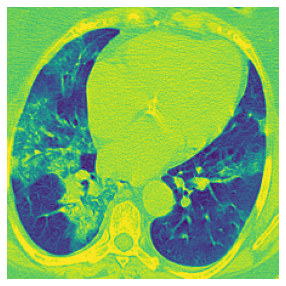

In [29]:
img = Image.open('/mnt/sfs_turbo/public_medical_images/datasets/selected4finetune/sarscov2-ctscan-dataset/COVID/Covid (1000).png')
print(np.array(img).shape)
img = img.resize((224, 224))
img = np.array(img)[:, :, 0] / 255.

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

In [32]:
img = Image.open('/mnt/sfs_turbo/public_medical_images/datasets/selected4finetune/sarscov2-ctscan-dataset/COVID/Covid (1000).png')
img = np.array(img) / 255.
print(img[:, :, 0])

[[0.81176471 0.8        0.79215686 ... 0.83921569 0.83921569 0.82745098]
 [0.80784314 0.80392157 0.80392157 ... 0.81176471 0.79215686 0.78431373]
 [0.85882353 0.86666667 0.87058824 ... 0.72156863 0.73333333 0.76470588]
 ...
 [0.85490196 0.8627451  0.81176471 ... 0.87058824 0.88627451 0.87843137]
 [0.80392157 0.83137255 0.79607843 ... 0.94509804 0.87058824 0.8627451 ]
 [0.80392157 0.83137255 0.80392157 ... 0.91764706 0.92156863 0.99215686]]


In [33]:
print(img[:, :, 1])

[[0.81176471 0.8        0.79215686 ... 0.83921569 0.83921569 0.82745098]
 [0.80784314 0.80392157 0.80392157 ... 0.81176471 0.79215686 0.78431373]
 [0.85882353 0.86666667 0.87058824 ... 0.72156863 0.73333333 0.76470588]
 ...
 [0.85490196 0.8627451  0.81176471 ... 0.87058824 0.88627451 0.87843137]
 [0.80392157 0.83137255 0.79607843 ... 0.94509804 0.87058824 0.8627451 ]
 [0.80392157 0.83137255 0.80392157 ... 0.91764706 0.92156863 0.99215686]]


In [34]:
print(img[:, :, 2])

[[0.81176471 0.8        0.79215686 ... 0.83921569 0.83921569 0.82745098]
 [0.80784314 0.80392157 0.80392157 ... 0.81176471 0.79215686 0.78431373]
 [0.85882353 0.86666667 0.87058824 ... 0.72156863 0.73333333 0.76470588]
 ...
 [0.85490196 0.8627451  0.81176471 ... 0.87058824 0.88627451 0.87843137]
 [0.80392157 0.83137255 0.79607843 ... 0.94509804 0.87058824 0.8627451 ]
 [0.80392157 0.83137255 0.80392157 ... 0.91764706 0.92156863 0.99215686]]


### Load a pre-trained MAE model

In [30]:
chkpt_dir = '/mnt/sfs_turbo/jiaoxianfeng/code/ssl-pretrain/mae/output_dir_0315/checkpoint-799.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
print('Model loaded.')

<All keys matched successfully>
Model loaded.


MAE with pixel reconstruction:


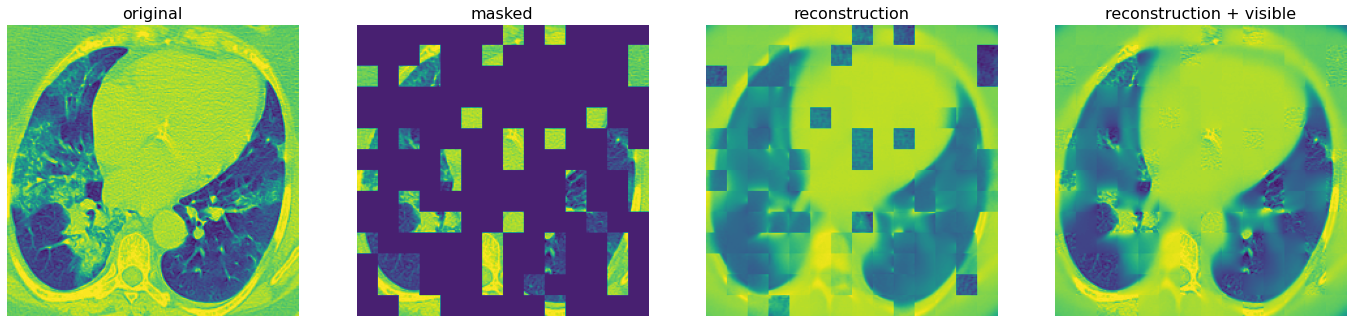

In [31]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img, model_mae)